# Libraries

In [1]:
import cv2 as cv
import numpy as np
import os
from skimage.transform import resize
import matplotlib.pyplot as plt

# Functions

In [2]:
def vs_to_colab(place='local'):
    """This function is to set the path of the working place, depending if we are working online or local

    Args:
        place (str): Name of the place. Two options. Defaults to 'local'.
    """
    if (place=='local'):
        os.chdir('/home/ricardino/Documents/MAIA/tercer_semestre/CAD/Projecte_1')
    elif (place=='online'):
        os.chdir('/home/ricardino/Documents/MAIA/tercer_semestre/CAD/Projecte_1')
    else:
        print('Not accepted working place, try again')


#function that performs the sum of the structure elements in different directions
def sum_operation_se_different_directions(img,operation, width,height,n_se):
    """This function performes the sum of the structure element in different direction

    Args:
        img (array): image to process
        operation (cv.method): top-hat, buttom-hat
        width (int): width of stucturing element
        height (int): geight of the structuring element
        n_se (int): number of angles

    Returns:
        _type_: _description_
    """
    # create SEs
    base = np.zeros([width, width])
    k = int(width / 2 - height / 2)
    while k <= (width / 2 + height / 2):
        base = cv.line(base, (0, k), (width, k), 255) #drawing a line
        k = k + 1
    
    SEs = []
    SEs.append(base)
    angle = 180.0 / n_se
    #Aplying affine transformations to the elements 
    for k in range(1, n_se):
        SEs.append(cv.warpAffine(base, cv.getRotationMatrix2D((base.shape[0] / 2, base.shape[1] / 2), k * angle, 1.0),(width, width)))
    
    #Performing the sum of the elements with a morphology operation, in this case blackhats
    open_sum = np.uint16(0*cv.morphologyEx(img, operation, np.uint8(SEs[0])))
    for se in SEs:
        open_sum += cv.morphologyEx(img, operation, np.uint8(se))
    #Applying the normalization
    result= cv.normalize(open_sum, 0, 255, norm_type=cv.NORM_MINMAX)
    return np.uint8(result)


def smplextract_hair(src):
    """This function inputs an skin lesion image and returns the preprocessed image without hairs and enhancing contrast.

    Args:
        src (3-channel array): Input image in 3 channels

    Returns:
        3-channel array: preprocessed image
    """
    
    # Convert the original image to grayscale
    img_gray=cv.cvtColor(src,cv.COLOR_BGR2GRAY)
    #Applying the contrast enhance to the image, setting a contrast limit to avoid noise amplification
    clahe = cv.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
    contrast_enhanced_gray_img = clahe.apply(img_gray)

    #Selecting the size and number of structure elements
    width= 29
    height=2
    n_se=15
    
    #cv.imshow("original_image",src)
    #Performing the sum of black hats in order to obtain the contours of the hairs with respect to the direction
    sum_black_hats=sum_operation_se_different_directions(contrast_enhanced_gray_img,cv.MORPH_BLACKHAT, width,height,n_se)
    #cv.imshow("sum_blackhats", sum_black_hats)
    #Applying the threshold to increase the pixel intensities in the mask
    ret, bin_img = cv.threshold(sum_black_hats, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    #cv.imshow("Thresholded Mask",bin_img)
    #Applying dilation to prepare the mask for the next step
    dilated_bin_img=cv.dilate(bin_img,cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)))
    #cv.imshow("dilated", dilated_bin_img)
    # Inpaint the original image depending on the mask
    dst = cv.inpaint(src,dilated_bin_img,7,cv.INPAINT_TELEA)
    #cv.imshow("Inpaint",dst)
    #cv.waitKey(50)
    return dst

    

# Tests

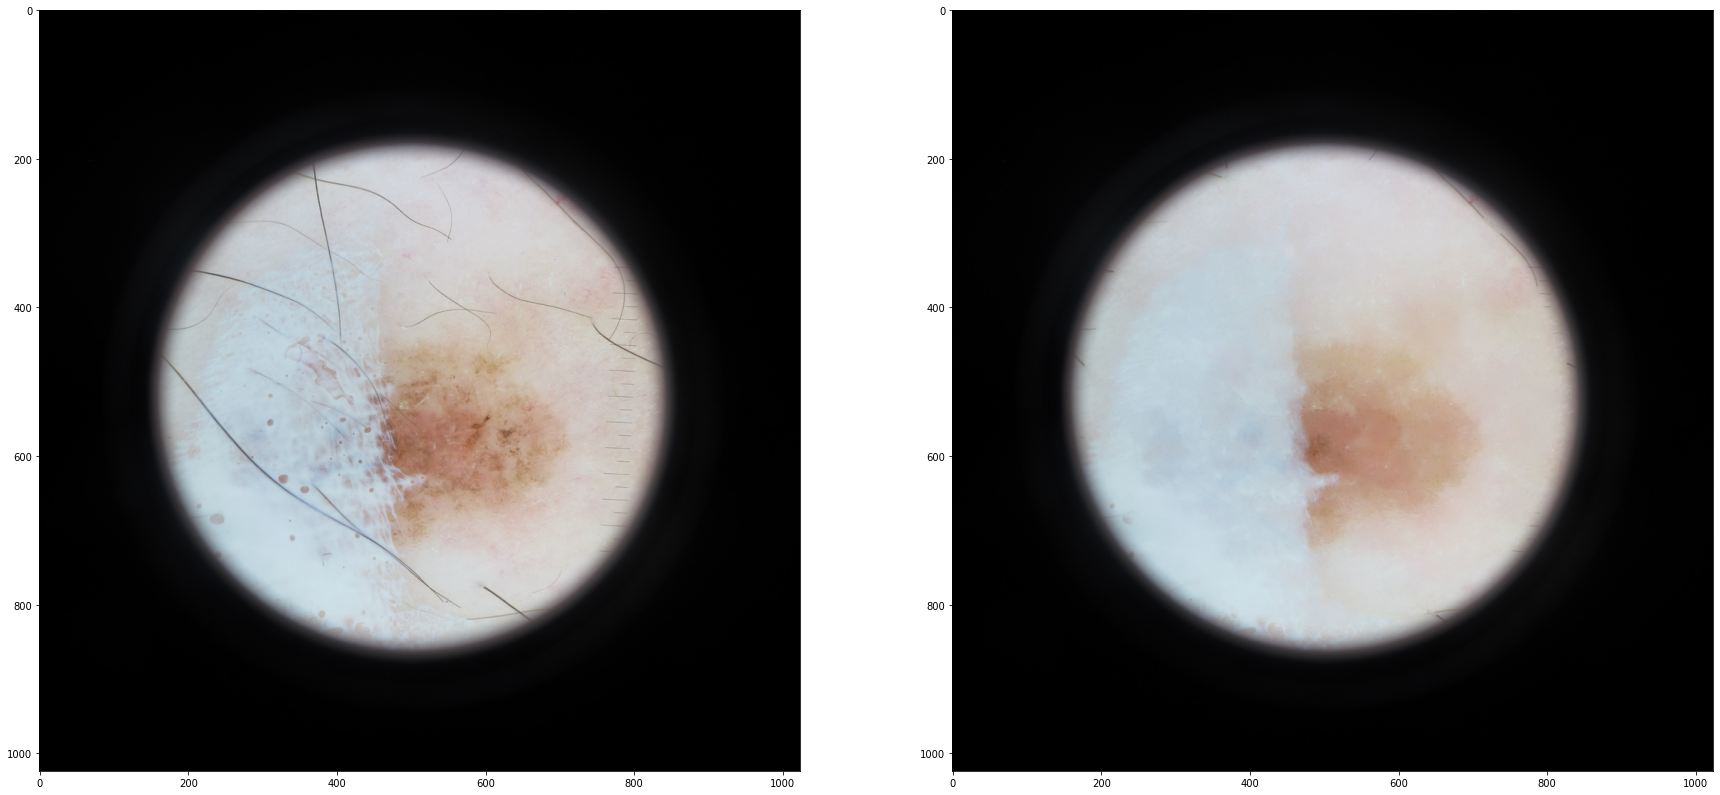

In [3]:
vs_to_colab(place='local')
path_image = 'images/binary/train/nevus/nev00002.jpg'

#Read image and show
im = cv.cvtColor(cv.imread(path_image), cv.COLOR_BGR2RGB)

im_nh = smplextract_hair(im)

fig, axs = plt.subplots(1,2, figsize=(30,30))
axs[0].imshow(im)
axs[1].imshow(im_nh)
